# Numerical Methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from interpolation import interp
from scipy.optimize import minimize_scalar, bisect

In [2]:
def c_star(x, β, γ):

    return (1 - β ** (1/γ)) * x


def v_star(x, β, γ):

    return (1 - β**(1 / γ))**(-γ) * (x**(1-γ) / (1-γ))

In [3]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

In [4]:
class CakeEating:

    def __init__(self,
                 β=0.96,           # discount factor
                 γ=1.5,            # degree of relative risk aversion
                 x_grid_min=1e-3,  # exclude zero for numerical stability
                 x_grid_max=2.5,   # size of cake
                 x_grid_size=120):

        self.β, self.γ = β, γ

        # Set up grid
        self.x_grid = np.linspace(x_grid_min, x_grid_max, x_grid_size)

    # Utility function
    def u(self, c):

        γ = self.γ

        if γ == 1:
            return np.log(c)
        else:
            return (c ** (1 - γ)) / (1 - γ)

    # first derivative of utility function
    def u_prime(self, c):

        return c ** (-self.γ)

    def state_action_value(self, c, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        u, β = self.u, self.β
        v = lambda x: interp(self.x_grid, v_array, x)

        return u(c) + β * v(x - c)

In [5]:
def T(v, ce):
    """
    The Bellman operator.  Updates the guess of the value function.

    * ce is an instance of CakeEating
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)

    for i, x in enumerate(ce.x_grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(ce.state_action_value, 1e-10, x, (x, v))[1]

    return v_new

In [6]:
ce = CakeEating()

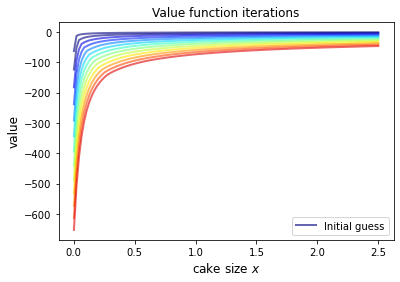

In [7]:
x_grid = ce.x_grid
v = ce.u(x_grid)       # Initial guess
n = 12                 # Number of iterations

fig, ax = plt.subplots()

ax.plot(x_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial guess')

for i in range(n):
    v = T(v, ce)  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.legend()
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('cake size $x$', fontsize=12)
ax.set_title('Value function iterations')

plt.show()

In [8]:
def compute_value_function(ce,
                           tol=1e-4,
                           max_iter=1000,
                           verbose=True,
                           print_skip=25):

    # Set up loop
    v = np.zeros(len(ce.x_grid)) # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v, ce)

        error = np.max(np.abs(v - v_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

In [9]:
v = compute_value_function(ce)

Error at iteration 25 is 23.8003755134813.
Error at iteration 50 is 8.577577195046615.
Error at iteration 75 is 3.091330659691039.
Error at iteration 100 is 1.1141054204751981.
Error at iteration 125 is 0.4015199357729671.
Error at iteration 150 is 0.14470646660561215.
Error at iteration 175 is 0.052151735472762084.
Error at iteration 200 is 0.018795314242879613.
Error at iteration 225 is 0.006773769545588948.
Error at iteration 250 is 0.0024412443051460286.
Error at iteration 275 is 0.000879816432870939.
Error at iteration 300 is 0.00031708295392718355.
Error at iteration 325 is 0.00011427565573285392.

Converged in 329 iterations.


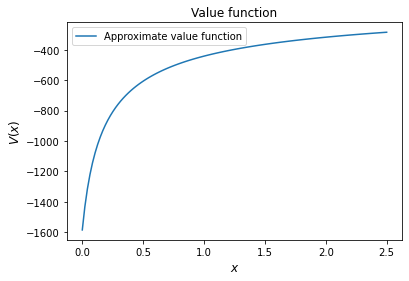

In [10]:
fig, ax = plt.subplots()

ax.plot(x_grid, v, label='Approximate value function')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.set_title('Value function')
ax.legend()
plt.show()

In [11]:
v_analytical = v_star(ce.x_grid, ce.β, ce.γ)

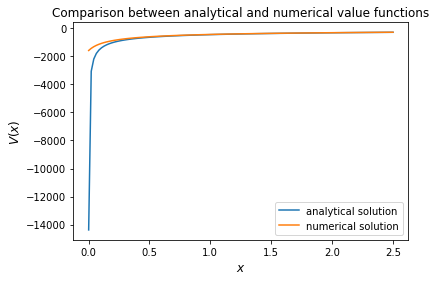

In [12]:
fig, ax = plt.subplots()

ax.plot(x_grid, v_analytical, label='analytical solution')
ax.plot(x_grid, v, label='numerical solution')
ax.set_ylabel('$V(x)$', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)
ax.legend()
ax.set_title('Comparison between analytical and numerical value functions')
plt.show()

In [13]:
def σ(ce, v):
    """
    The optimal policy function. Given the value function,
    it finds optimal consumption in each state.

    * ce is an instance of CakeEating
    * v is a value function array

    """
    c = np.empty_like(v)

    for i in range(len(ce.x_grid)):
        x = ce.x_grid[i]
        # Maximize RHS of Bellman equation at state x
        c[i] = maximize(ce.state_action_value, 1e-10, x, (x, v))[0]

    return c

In [14]:
c = σ(ce, v)

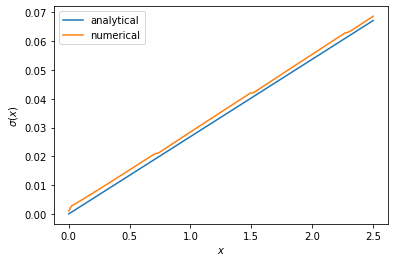

In [15]:
c_analytical = c_star(ce.x_grid, ce.β, ce.γ)

fig, ax = plt.subplots()

ax.plot(ce.x_grid, c_analytical, label='analytical')
ax.plot(ce.x_grid, c, label='numerical')
ax.set_ylabel(r'$\sigma(x)$')
ax.set_xlabel('$x$')
ax.legend()

plt.show()

In [16]:
class OptimalGrowth(CakeEating):
    """
    A subclass of CakeEating that adds the parameter α and overrides
    the state_action_value method.
    """

    def __init__(self,
                 β=0.96,           # discount factor
                 γ=1.5,            # degree of relative risk aversion
                 α=0.4,            # productivity parameter
                 x_grid_min=1e-3,  # exclude zero for numerical stability
                 x_grid_max=2.5,   # size of cake
                 x_grid_size=120):

        self.α = α
        CakeEating.__init__(self, β, γ, x_grid_min, x_grid_max, x_grid_size)

    def state_action_value(self, c, x, v_array):
        """
        Right hand side of the Bellman equation given x and c.
        """

        u, β, α = self.u, self.β, self.α
        v = lambda x: interp(self.x_grid, v_array, x)

        return u(c) + β * v((x - c)**α)

In [17]:
og = OptimalGrowth()

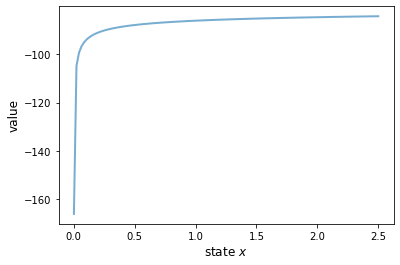

In [18]:
v = compute_value_function(og, verbose=False)

fig, ax = plt.subplots()

ax.plot(x_grid, v, lw=2, alpha=0.6)
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('state $x$', fontsize=12)

plt.show()

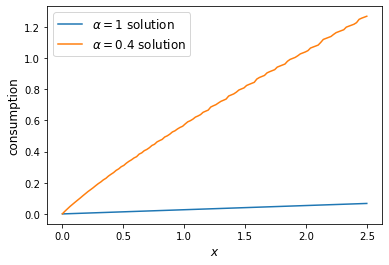

In [19]:
c_new = σ(og, v)

fig, ax = plt.subplots()

ax.plot(ce.x_grid, c_analytical, label=r'$\alpha=1$ solution')
ax.plot(ce.x_grid, c_new, label=fr'$\alpha={og.α}$ solution')

ax.set_ylabel('consumption', fontsize=12)
ax.set_xlabel('$x$', fontsize=12)

ax.legend(fontsize=12)

plt.show()

In [20]:
def K(σ_array, ce):
    """
    The policy function operator. Given the policy function,
    it updates the optimal consumption using Euler equation.

    * σ_array is an array of policy function values on the grid
    * ce is an instance of CakeEating

    """

    u_prime, β, x_grid = ce.u_prime, ce.β, ce.x_grid
    σ_new = np.empty_like(σ_array)

    σ = lambda x: interp(x_grid, σ_array, x)

    def euler_diff(c, x):
        return u_prime(c) - β * u_prime(σ(x - c))

    for i, x in enumerate(x_grid):

        # handle small x separately --- helps numerical stability
        if x < 1e-12:
            σ_new[i] = 0.0

        # handle other x
        else:
            σ_new[i] = bisect(euler_diff, 1e-10, x - 1e-10, x)

    return σ_new

In [21]:
def iterate_euler_equation(ce,
                           max_iter=500,
                           tol=1e-5,
                           verbose=True,
                           print_skip=25):

    x_grid = ce.x_grid

    σ = np.copy(x_grid)        # initial guess

    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        σ_new = K(σ, ce)

        error = np.max(np.abs(σ_new - σ))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ

In [22]:
ce = CakeEating(x_grid_min=0.0)
c_euler = iterate_euler_equation(ce)

Error at iteration 25 is 0.0036456675931543225.
Error at iteration 50 is 0.0008283185047067848.
Error at iteration 75 is 0.00030791132300957147.
Error at iteration 100 is 0.00013555502390599772.
Error at iteration 125 is 6.417740905302616e-05.
Error at iteration 150 is 3.1438019047758115e-05.
Error at iteration 175 is 1.5658492883291464e-05.

Converged in 192 iterations.


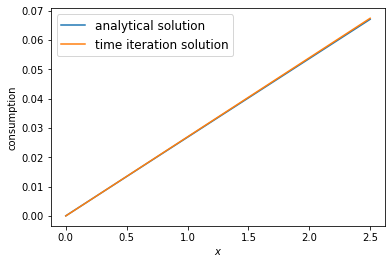

In [23]:
fig, ax = plt.subplots()

ax.plot(ce.x_grid, c_analytical, label='analytical solution')
ax.plot(ce.x_grid, c_euler, label='time iteration solution')

ax.set_ylabel('consumption')
ax.set_xlabel('$x$')
ax.legend(fontsize=12)

plt.show()